In [ ]:
!wget --header 'Host: storage.googleapis.com' --user-agent 'Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:87.0) Gecko/20100101 Firefox/87.0' --header 'Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,*/*;q=0.8' --header 'Accept-Language: en-US,en;q=0.5' --header 'Upgrade-Insecure-Requests: 1' 'https://storage.googleapis.com/kaggle-competitions-data/kaggle-v2/5144/862050/bundle/archive.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1619330926&Signature=TE%2BGGQsC%2FbpTt3lqGkCFHaiLT6wQTPgL60%2B9LX4%2BZBS8%2FCNOsENnM7aE0zhY3UKoXYtdQE7obSmWZjZolkRhrG0c%2Bl0o8Q62hdrlSUOlY5jP08ZbW5i9MQMv0lFEjuIxCCSNiriBPx7puqUABCLsCLMzJh3qAntyCuCecFr3BQRxSp7b6a4ptaRluECUjKSElQqFVwr38HMAloivuffuBEly40%2FoRuFDncGnww4YQfJ%2BVtm5246osVPy6ZZKydOiTD32aR3cs8FZWZ798NIXYsYvOr4eVXu%2BpTHhCMW6%2BeSmSU3SCayVGp0jcdkQ%2Ff7e%2FSReqltZ8Eq2Go4%2BOEaSxA%3D%3D&response-content-disposition=attachment%3B+filename%3Dultrasound-nerve-segmentation.zip' --output-document 'ultrasound-nerve-segmentation.zip'
# !pip install q keras==2.4.1
# !pip install segmentation_models
# !pip install tensorflow_io
!unzip '/content/ultrasound-nerve-segmentation.zip'

In [6]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import cv2
from PIL import Image
from skimage.transform import resize
from sklearn.model_selection import train_test_split, KFold
import tensorflow_io as tfio
import keras
import tensorflow as tf
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint
plt.style.use("ggplot")
%matplotlib inline
from skimage.measure import compare_ssim as ssim
from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from PIL import Image,ImageFilter
K.set_image_data_format('channels_last')

#Data preprocessing 

In [7]:
#creating train and test dataframes of images
file_path=pd.DataFrame({'image_path':os.listdir('/content/train')})
file_path_test=pd.DataFrame({'image_path':os.listdir('/content/test')})

In [8]:
#getting subject and image name from train data
subject=file_path.image_path.apply(lambda x:re.split('_',x)[0])
img_name=file_path_test.image_path.apply(lambda x:x.split('.')[0])

In [9]:
grb=file_path.image_path.apply(lambda x:re.search('_[0-9]+',x).group())
image_name=grb.apply(lambda x:re.split('_',x)[1])

In [10]:
#adding two columns image name and subject name
file_path['image_name']=image_name
file_path['subject_name']=subject
file_path_test['image_name']=img_name

In [11]:
#adding file location to file name.
file_path.image_path=file_path.image_path.apply(lambda x:'train/'+x)
file_path_test.image_path=file_path_test.image_path.apply(lambda x:'test/'+x)

In [12]:
#separating mask images from train images
msk=[i for i in range(len(file_path.image_path)) if 'mask' in file_path.image_path[i]]
img=[i for i in range(len(file_path.image_path)) if 'mask' not in file_path.image_path[i]]
msk=file_path.loc[msk]
img=file_path.loc[img]

In [13]:
#aligning both to be concatenated later
msk=msk.sort_values(by=['image_name','subject_name'])
img=img.sort_values(by=['image_name','subject_name'])

In [14]:
#adding mask image path to the df
img['mask_path']=msk.image_path.values

In [15]:
print('Number of unique subjects',len(img.subject_name.value_counts()))
print('Number of images per subject',len(img.image_name.value_counts()))

Number of unique subjects 47
Number of images per subject 120


In [16]:
img.head()

,image_path,image_name,subject_name,mask_path
10088,train/1_1.tif,1,1,train/1_1_mask.tif
6998,train/10_1.tif,1,10,train/10_1_mask.tif
2298,train/11_1.tif,1,11,train/11_1_mask.tif
10602,train/12_1.tif,1,12,train/12_1_mask.tif
7704,train/13_1.tif,1,13,train/13_1_mask.tif


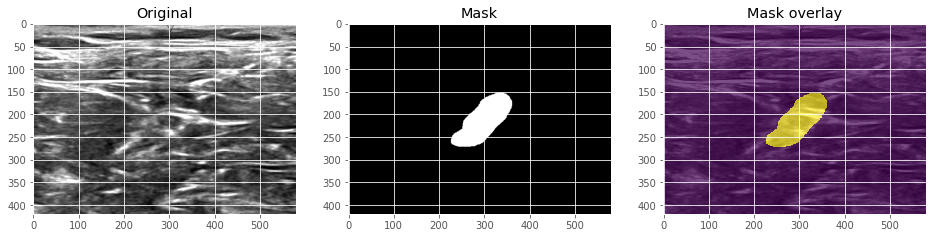

In [17]:
#visualising a single ultrasound image and its mask
img_arr=np.array(Image.open(img.iloc[5].image_path))
image1_mask = np.array(Image.open(img.iloc[5].mask_path))
fig, ax = plt.subplots(1,3,figsize = (16,12))
ax[0].imshow(img_arr, cmap = 'gray')
ax[0].set_title('Original')

ax[1].imshow(image1_mask, cmap = 'gray')
ax[1].set_title('Mask')
ax[2].imshow(img_arr, cmap = 'gray', interpolation = 'none')
ax[2].imshow(image1_mask, interpolation = 'none', alpha = 0.7)
ax[2].set_title('Mask overlay')
plt.show()

In [19]:
#creating an array that will store all images in 12*12 resized format
X1 = np.zeros((len(img), 12, 12), dtype=np.float32)
for i in range(len(img)):
  img1=cv2.imread(img.image_path.iloc[i],cv2.IMREAD_GRAYSCALE)
  img1=resize(img1, (12, 12), mode = 'constant', preserve_range = True)
  X1[i]=img1

In [ ]:
#finding similarity between resized images and storing it in a dictionary
from tqdm import tqdm
sim=dict()
for i in tqdm(range(len(X1))):
  for j in range(len(X1)):
      if i!=j:
        if tuple(sorted((i,j))) not in sim.keys():
          simil=ssim(X1[i],X1[j])
          if abs(simil)>0.95:
            sim[tuple(sorted((i,j)))]=simil

In [29]:
from tqdm import tqdm

In [30]:
#storing conflicting images' keys in a list if their similarity is >0.99 in their resized form
conf=[]
for i in tqdm(sim.keys()):
  if sim[i]>0.999:
    msk1=cv2.imread(img.mask_path.iloc[i[0]],cv2.IMREAD_GRAYSCALE)
    msk2=cv2.imread(img.mask_path.iloc[i[1]],cv2.IMREAD_GRAYSCALE)
    if msk1.any()!=msk2.any():
      conf.append(i)

100%|██████████| 18788/18788 [00:03<00:00, 5124.27it/s]


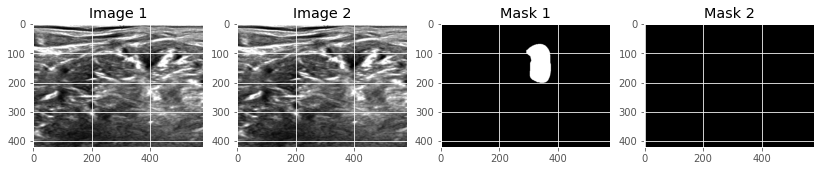

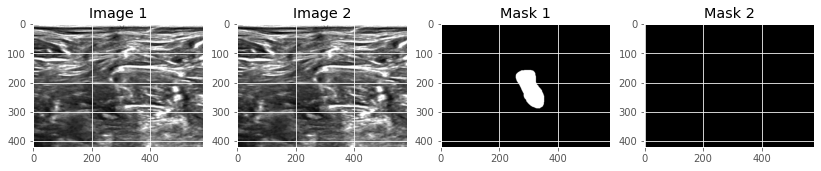

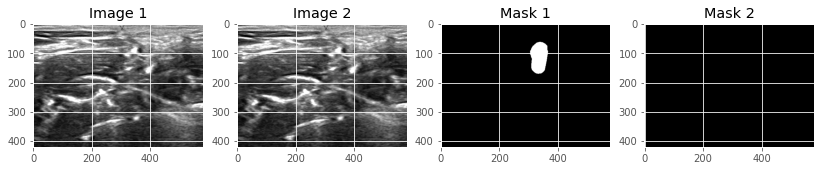

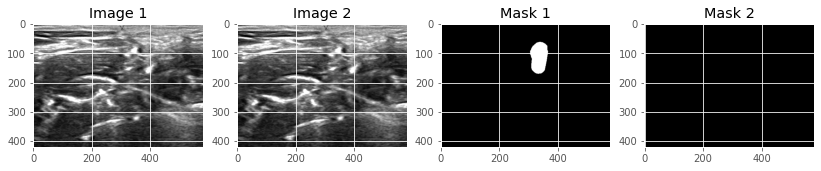

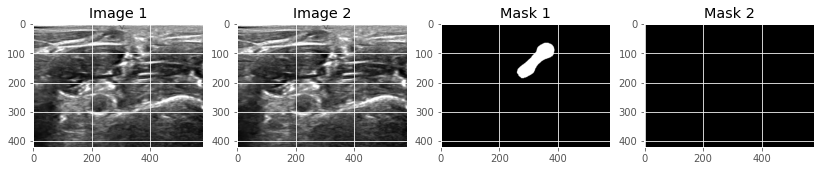

In [31]:
#plotting few of the conflicting image and mask pairs
cnt=0
for i in conf:
  fig,ax=plt.subplots(1,4,figsize=(14,7))
  cnt+=1
  img1=cv2.imread(img.image_path.iloc[i[0]],cv2.IMREAD_GRAYSCALE)
  ax[0].imshow(img1,cmap='gray')
  ax[0].set_title('Image 1')
  img2=cv2.imread(img.image_path.iloc[i[1]],cv2.IMREAD_GRAYSCALE)
  ax[1].imshow(img2,cmap='gray')
  ax[1].set_title('Image 2')
  msk1=cv2.imread(img.mask_path.iloc[i[0]],cv2.IMREAD_GRAYSCALE)
  ax[2].imshow(msk1,cmap='gray')
  ax[2].set_title('Mask 1')
  msk2=cv2.imread(img.mask_path.iloc[i[1]],cv2.IMREAD_GRAYSCALE)
  ax[3].imshow(msk2,cmap='gray')
  ax[3].set_title('Mask 2')
  if cnt==5:
    break


As you can see above we have similar looking images but having different masks them. This might confuse the model training.

In [ ]:
#out of conflicting image pair dropping the image that doesn't contains a mask
indices=[img.iloc[i[1]].name if cv2.imread(img.mask_path.iloc[i[0]],
                                           cv2.IMREAD_GRAYSCALE).any()==True else img.iloc[i[0]].name for i in conf]
indices=list(set(indices))
img.drop(indices,axis=0,inplace=True)

In [ ]:
img.to_csv('dup_rem.csv')